In [78]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import torch
from tqdm import tqdm

from dataset.TwoMoonDataset import TwoMoonDataset
from sklearn import datasets

from flow_models.PatchFlowModel import PatchFlowModel
from trainer import log_likelihood_loss


In [79]:

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [61]:
def get_batch(samples):
    data, _ = datasets.make_moons(n_samples=samples, noise=0.06)
    return torch.from_numpy(np.array(data, dtype=np.float32))


In [62]:
batch = get_batch(512)
batch.shape

torch.Size([512, 2])

In [63]:
x, y= zip(*batch)

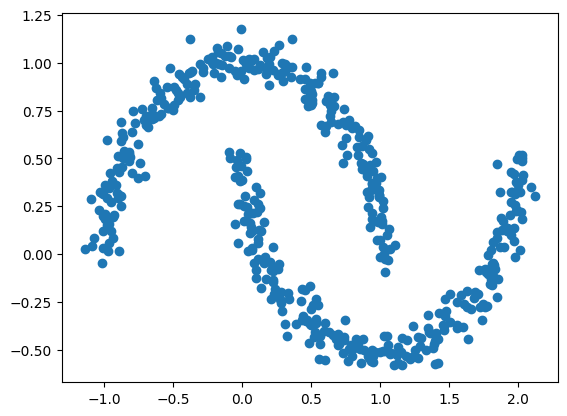

In [64]:
plt.scatter(x, y)

In [69]:
flow = PatchFlowModel(hparams={"num_layers": 17, "sub_net_size": 64, "dimension": 2}, device=DEVICE)
flow.to(DEVICE)

PatchFlowModel(
  (model): ReversibleGraphNet(
    (module_list): ModuleList(
      (0): GLOWCouplingBlock(
        (subnet1): Sequential(
          (0): Linear(in_features=1, out_features=64, bias=True)
          (1): ReLU()
          (2): Linear(in_features=64, out_features=64, bias=True)
          (3): ReLU()
          (4): Linear(in_features=64, out_features=2, bias=True)
        )
        (subnet2): Sequential(
          (0): Linear(in_features=1, out_features=64, bias=True)
          (1): ReLU()
          (2): Linear(in_features=64, out_features=64, bias=True)
          (3): ReLU()
          (4): Linear(in_features=64, out_features=2, bias=True)
        )
      )
      (1): PermuteRandom()
      (2): GLOWCouplingBlock(
        (subnet1): Sequential(
          (0): Linear(in_features=1, out_features=64, bias=True)
          (1): ReLU()
          (2): Linear(in_features=64, out_features=64, bias=True)
          (3): ReLU()
          (4): Linear(in_features=64, out_features=2, bias=

In [70]:
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-4)

In [71]:
bar = tqdm(range(8000))
loss_g = []
for i in bar:
    loss = 0
    z, z_log_det = flow(get_batch(512).to(DEVICE), rev=True)
    loss += log_likelihood_loss(z, z_log_det)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_g.append((i, loss.item()))
    bar.set_description_str(f'loss: {loss.item()}')



loss: -1.406843662261963: 100%|██████████| 8000/8000 [05:58<00:00, 22.29it/s] 


In [80]:
torch.save(flow.get_state(), 'results/moon_flow.pth')

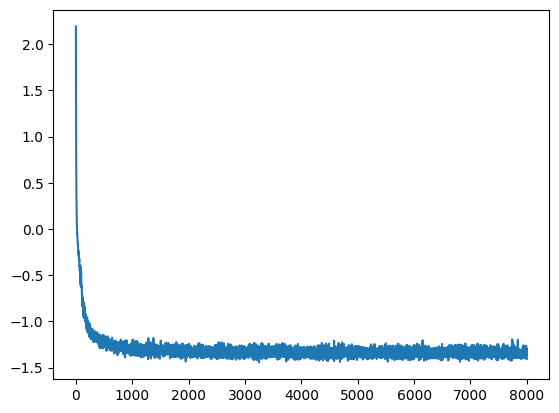

In [81]:
x, y = zip(*loss_g)
plt.plot(x, y)

In [87]:
mean = np.zeros(2)
cov = np.eye(2)
cov

array([[1., 0.],
       [0., 1.]])

In [89]:
np.random.multivariate_normal(np.zeros(2), np.eye(2), 512)

array([[-0.35655838,  0.28884008],
       [-0.79637599,  1.7547002 ],
       [ 0.84167758, -0.17426996],
       ...,
       [ 0.36430684,  1.06011425],
       [ 0.28802743,  0.22115908],
       [-1.09433158, -0.03657286]])

In [90]:
loaded_flow = PatchFlowModel(path='results/moon_flow.pth')

In [113]:
z, log_det = loaded_flow(torch.tensor(np.random.multivariate_normal(np.zeros(2), np.eye(2), 1500), dtype=torch.float))

In [114]:
xr, yr = zip(*z.detach().numpy())

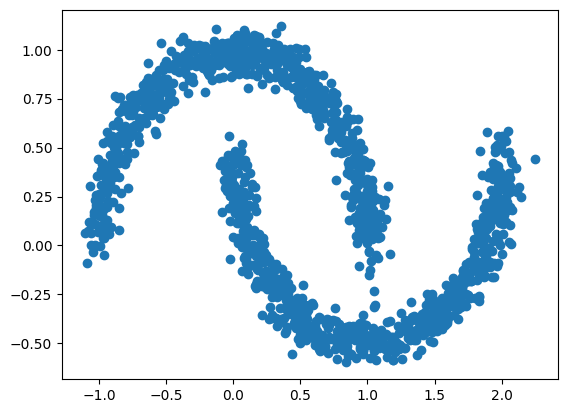

In [115]:
plt.scatter(xr, yr)

In [108]:
a, b  = zip(*np.random.multivariate_normal(np.zeros(2), np.eye(2), 1500))

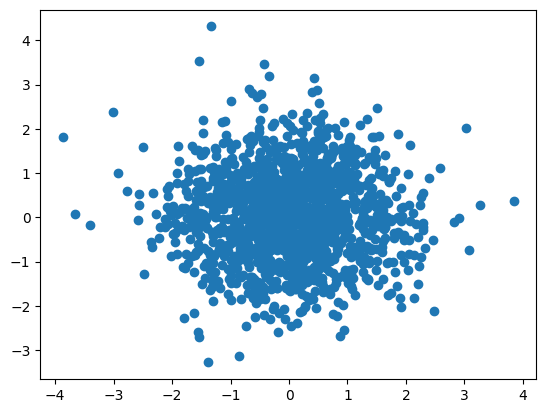

In [109]:
plt.scatter(a,b)